In [1]:
import layoutparser as lp
import cv2

In [2]:
image = cv2.imread("images/Capture_1.JPG")
image = image[..., ::-1]

In [3]:
model = lp.Detectron2LayoutModel('config.yml',model_path = 'model_final.pth',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

In [4]:
layout = model.detect(image)

C:\Users\91992\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
detected_image = lp.draw_box(image, layout, box_width=3, show_element_type= True)

In [10]:
import numpy as np
cv2.imshow('Image',cv2.cvtColor(np.array(detected_image), cv2.COLOR_BGR2RGB))
cv2.waitKey(0)
cv2.destroyAllWindows()

## Check the results from the model

In [6]:
type(layout)

layoutparser.elements.layout.Layout

In [7]:
layout.to_dataframe()

,x_1,y_1,x_2,y_2,block_type,type,score
0,13.974309,20.639992,539.335999,272.179626,rectangle,Figure,0.993361
1,50.656639,484.525421,281.618469,517.606018,rectangle,Text,0.992870
2,48.534290,360.641266,284.039673,395.709686,rectangle,Text,0.990544
3,305.375427,361.090820,542.553589,396.113586,rectangle,Text,0.989626
4,306.875366,560.846252,376.526398,573.688354,rectangle,Title,0.988223
5,48.825146,275.264679,532.962769,346.845184,rectangle,Text,0.980732
6,305.204926,476.435760,543.717651,549.892761,rectangle,Text,0.958862
7,47.109825,593.806519,283.905212,614.000000,rectangle,Text,0.938833
8,45.530849,532.495544,285.347992,592.165039,rectangle,Text,0.936456
9,55.020966,404.743561,286.366669,482.575958,rectangle,Table,0.881434


In [8]:
layout[0]

TextBlock(block=Rectangle(x_1=13.974308967590332, y_1=20.639991760253906, x_2=539.3359985351562, y_2=272.17962646484375), text=None, id=None, type=Figure, parent=None, next=None, score=0.9933605790138245)

## filter text region of specific type

In [9]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [10]:
type(figure_blocks[0])

layoutparser.elements.layout_elements.TextBlock

In [11]:
## As there could be text region detected inside the figure region, we just drop them
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

## Finally sort the text regions and assign ids

In [16]:

h, w = image.shape[:2]


In [17]:
left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

In [18]:
type(left_interval)

layoutparser.elements.layout_elements.Interval

In [19]:
left_blocks = text_blocks.filter_by(left_interval, center=True)

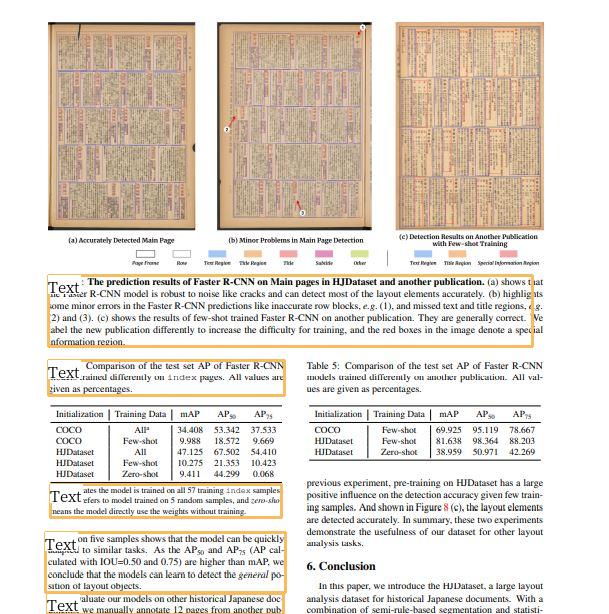

In [20]:
lp.draw_box(image, left_blocks, box_width=3, show_element_type= True)

In [21]:
for i in left_blocks:
    print(i.coordinates)

(50.656639099121094, 484.5254211425781, 281.61846923828125, 517.6060180664062)
(48.5342903137207, 360.6412658691406, 284.0396728515625, 395.7096862792969)
(48.82514572143555, 275.2646789550781, 532.9627685546875, 346.8451843261719)
(47.109825134277344, 593.8065185546875, 283.90521240234375, 614.0)
(45.53084945678711, 532.4955444335938, 285.3479919433594, 592.1650390625)


In [22]:
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

In [23]:
for i in left_blocks:
    print(i.coordinates)

(48.82514572143555, 275.2646789550781, 532.9627685546875, 346.8451843261719)
(48.5342903137207, 360.6412658691406, 284.0396728515625, 395.7096862792969)
(50.656639099121094, 484.5254211425781, 281.61846923828125, 517.6060180664062)
(45.53084945678711, 532.4955444335938, 285.3479919433594, 592.1650390625)
(47.109825134277344, 593.8065185546875, 283.90521240234375, 614.0)


In [24]:
right_blocks = [b for b in text_blocks if b not in left_blocks]


In [25]:
# right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

In [26]:
for i in right_blocks:
    print(i.coordinates[1])

361.0908203125
476.4357604980469
580.3292846679688


In [27]:
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

In [28]:
type(text_blocks)

layoutparser.elements.layout.Layout

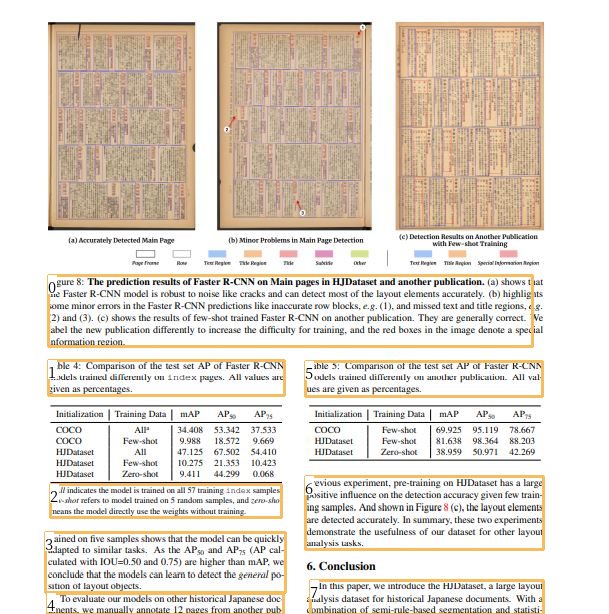

In [29]:
lp.draw_box(image, text_blocks,
            box_width=3,
            show_element_id=True)

## Fetch the text inside each text region

In [30]:
# pip install layoutparser[ocr]
ocr_agent = lp.TesseractAgent(languages='eng')

In [34]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [35]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness
    print
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [27]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
    print(segment_image)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [251 251 251]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [252 253 255]
  [254 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [251 255 255]
  [250 255 255]
  [254 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 251]
  [255 255 253]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 253]
  [255 255 253]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 253]
  [255 255 253]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

In [50]:
with open('random.txt', 'w+') as f:
    
    for txt in text_blocks:
#         print(txt, end='\n---\n')
        f.write(str(txt.id) + '\n-------------------------\n')
        f.write(txt.text)

In [45]:
for i in text_blocks:
    print(i.text)

‘Figure 8: The prediction results of Faster R-CNN on Main pages in HJDataset and another publication. (2) shows th
the Faster R-CNN model is obus to nose ike enicks and ean detect most ofthe layout elements accurately. (b) highligh
‘some ino ero inthe Faster R-CNN predictions ike inaccurate ow blocks, (I), and missed text and te regions
{@) and (3). (6) shows the results of fen-shot sined Faster R-CNN on anther publication. They ae generally comer.
Take the new publication dffeenly to incease the dificuly for sing nd tered boxes inthe image deote a spec
Keteeietiagsegien:

‘Table 4: Comparison of the test set AP of Faster RCN
‘ives as peroennges.

“All indiates the model i tsined oo all $7 waning index samples.
‘Joho fest dl ned on co see saat

‘rained on five samples shows thatthe model can be quickly
‘apd to similar tasks. As the APyy and AP, (AP cal
‘ult with OU=0.50 snd 0.75) ae higher than MAP. we
‘iiclude atthe mls can ent tt he peel po-
‘ation of layout objects

‘To evaluate our